In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import skimage.io as io
import matplotlib.pyplot as plt
import json
import random
import shutil

import torch
import torchvision
import torchvision.transforms as T

import pycocotools.coco as coco
from pycocotools.coco import COCO
import panopticapi
from panopticapi.utils import id2rgb, rgb2id,  IdGenerator

In [2]:
## bg class is the single stuff class for all types of background
CLASSES = ['N/A', 'rebar', 'crack', 'spall', 'bg']

In [3]:
project_folder = '/media/App/tsai/capstone/'
coco_folder = os.path.join(project_folder, 'coco')

In [4]:
img_list = []
img_folder = os.path.join(project_folder, 'images')
for imgfile in os.listdir(img_folder):
    img_list.append(os.path.join(img_folder, imgfile))
    
    
total = len(img_list)
train_len = round(0.8*total)
val_len = round(0.2*total)
random.shuffle(img_list)
train_list = img_list[:train_len]
val_list = img_list[train_len:]

## Copy images to train and val locations
train_img_folder = os.path.join(coco_folder, 'train2017')
val_img_folder = os.path.join(coco_folder, 'val2017')

## copy train images to train folder
for ti in train_list:
    shutil.copy2(ti, train_img_folder)
for vi in val_list:
    shutil.copy2(vi, val_img_folder)

## reload train and val list from newly copied directories
train_list = []
for imgfile in os.listdir(train_img_folder):
    train_list.append(os.path.join(train_img_folder, imgfile))
    
    
val_list = []
for imgfile in os.listdir(val_img_folder):
    val_list.append(os.path.join(val_img_folder, imgfile))

# CREATE DETECTION JSON for coco bounding boxes (part 2)

In [ ]:
from pycocotools import mask
from skimage import measure
from scipy import ndimage

## creates the annotation payload in json tied to specific image id and cat id
def create_annotation_field(mask_img, ann_id, cat_id, img_id):
    ann_list = []
#     plt.imshow(mask_img)
#     plt.show()
    
    numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_img, 4, cv2.CV_32S)
    print(f'img id {img_id}, #regions is {numLabels-1}')
    for label in range(0, numLabels):
        x,y,w,h,area = stats[label]
        if (area<5):
            print(f'Skipping very small region!')
            continue
        
        actual_catid = cat_id
        if label==0:
            actual_catid = 4
    
        a_dict = {
            "segmentation": [],
            "area": int(area) ,
            "iscrowd": 0,
            "image_id": img_id,
            "bbox": [int(x),int(y),int(w),int(h)],
            "category_id": actual_catid,
            "id": ann_id
            }

        ## get segmentation
        temp_img = np.zeros(mask_img.shape, dtype=np.uint8)
        temp_img[:,:][labels == label] = 255
        
        ctrs = measure.find_contours(temp_img, 1)
        
        for ctr in ctrs:
            ctr = np.flip(ctr, axis=1)
            segmentation = ctr.ravel().tolist()
            a_dict["segmentation"].append(segmentation)
        ann_list.append(a_dict)
        ann_id += 1
        
    return ann_list


## this method creates the json for coco format, and also populates the segmentation array in each annotation.
## if there are multiple foreground objects, it creates annotation per object instead of a single bounding box
## covering multiple objects
def create_detr_segm_json(imgfile_list):
    img_idx = 0
    ann_idx = 0
    img_cocolist = []
    ann_cocolist = []
    
    for imgfile in imgfile_list:
#         print(f'processing {imgfile}')
        name_noext = os.path.splitext(os.path.basename(imgfile))[0]
        img = cv2.imread(imgfile)
        i_dict = {}
        i_dict['id'] = img_idx
        i_dict['width'] = img.shape[1]
        i_dict['height'] = img.shape[0]
        i_dict['file_name'] = os.path.basename(imgfile)
        i_dict['coco_url'] = imgfile
        
        
        ## get corresponding mask
        mask_dir = os.path.join(project_folder, 'masks')
#         print(f'maskdir {mask_dir}')
        a_catid = None
        maskfile = None
        if os.path.exists(os.path.join(mask_dir, f'{name_noext}rebar.jpg')):
            maskfile = os.path.join(mask_dir, f'{name_noext}rebar.jpg')
            a_catid = 1
        elif os.path.exists(os.path.join(mask_dir, f'{name_noext}crack.jpg')):
            maskfile = os.path.join(mask_dir, f'{name_noext}crack.jpg')
            a_catid = 2
        elif os.path.exists(os.path.join(mask_dir, f'{name_noext}spall.jpg')):
            maskfile = os.path.join(mask_dir, f'{name_noext}spall.jpg')
            a_catid = 3
            
        if a_catid is None:
            print(f'cannot find mask for {imgfile}!')
            continue
            
#         print(f'maskfile is {maskfile}')
        mask_img = cv2.imread(maskfile, cv2.IMREAD_GRAYSCALE).astype(np.uint8)
        _, mask_img = cv2.threshold(mask_img, 200, 255, cv2.THRESH_BINARY)
        
        for a_dict in create_annotation_field(mask_img, ann_idx, a_catid, img_idx):   
            ann_cocolist.append(a_dict)
            ann_idx += 1

        img_cocolist.append(i_dict)
        img_idx += 1
    
    
    cat_cocolist = [{'id':1, 'name': 'rebar', 'supercategory':''},
                    {'id':2, 'name': 'crack', 'supercategory':''},
                    {'id':3, 'name': 'spall', 'supercategory':''},
                    {'id':4, 'name': 'bg', 'supercategory':''}]
    
    
    all_cocolist = {'categories':cat_cocolist, 
                    'images': img_cocolist, 
                    'annotations': ann_cocolist}
    return all_cocolist

detection_annotation_folder = os.path.join(coco_folder, 'annotations')
annfile = os.path.join(detection_annotation_folder, 'instances_train2017.json')
cocolist = create_detr_segm_json(train_list)
# cocolist = create_json(train_list)
with open(annfile, 'w') as f:
    json.dump(cocolist, f)
    

annfile = os.path.join(detection_annotation_folder, 'instances_val2017.json')
# cocolist = create_json(val_list)
cocolist = create_detr_segm_json(val_list)
with open(annfile, 'w') as f:
    json.dump(cocolist, f)

# BBox annotation sample

loading annotations into memory...
Done (t=0.48s)
creating index...
index created!
[{'id': 1, 'name': 'rebar', 'supercategory': ''}, {'id': 2, 'name': 'crack', 'supercategory': ''}, {'id': 3, 'name': 'spall', 'supercategory': ''}, {'id': 4, 'name': 'bg', 'supercategory': ''}]
showing validation file 0002703.jpg


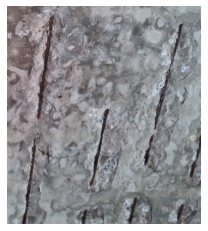

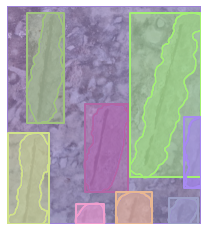

In [160]:
annfile = '/media/App/tsai/capstone/coco/annotations/instances_val2017.json'
## show a random file
coco = COCO(annfile)

cats = coco.loadCats(coco.getCatIds())
print(cats)

# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['rebar', 'crack', 'spall', 'bg']);
## 55,7,13 is good to show, 11 is pathological case
imgIds = coco.getImgIds(imgIds = [13])
img = coco.loadImgs(imgIds[0])[0]
print(f'showing validation file {img["file_name"]}')
I = io.imread(f'/media/App/tsai/capstone/coco/val2017/{img["file_name"]}')
plt.axis('off')
plt.imshow(I)
plt.show()

plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox = True)

# CREATE SEGMENTATION JSON for coco_panoptic

In [145]:
## save this off so we can restart kernel if needed. Keep same train list as one used for detection model
import pickle
with open('trainlist.pickle', 'wb') as f:
    pickle.dump(train_list, f)

with open('vallist.pickle', 'wb') as f:
    pickle.dump(val_list, f)
    
print(f'len trainlist {len(train_list)}, sample {train_list[0]}')

len trainlist 1154, sample /media/App/tsai/capstone/coco/train2017/0743.jpg


## We use the [IdGenerator](https://github.com/cocodataset/panopticapi/blob/7bb4655548f98f3fedc07bf37e9040a992b054b0/panopticapi/utils.py#L25) from panoptic API to assign RGB values corresponding to category ids and creating slightly differing RGB values for instance ids in the same category. This aligns with the same way the DETR codebase processes segments.

In [146]:
ann_cats = {1: {'isthing': 1, 'color':(255,0,0)},
            2: {'isthing': 1, 'color':(0,255,0)},
            3: {'isthing': 1, 'color':(0,0,255)},
            4: {'isthing': 0, 'color':(127,127,127)}}
idgen = IdGenerator(ann_cats)

In [147]:
def create_segments(mask_img, panoptic_mask_img, catid):
    seg_infos = []
    
    ## use connected components to find fg and bg regions
    ## first label is always BG
    numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_img, 4, cv2.CV_32S)
    print(f'#fg regions is {numLabels-1}')
    for label in range(0, numLabels):
        x,y,w,h,area = stats[label]
        if (area<5):
            print(f'Skipping very small region!')
            continue
        
        actual_catid = catid
        if label==0:
            actual_catid = 4
            
        sid, color = idgen.get_id_and_color(actual_catid)
        print(f'setting for id {actual_catid}: json_id={sid} png color={color}')
        seg_info = {}
        seg_info['id'] = sid
        seg_info['category_id'] = actual_catid
        seg_info['area'] = int(area)
        seg_info['bbox'] = [int(x),int(y),int(w),int(h)]
        seg_info['iscrowd'] = 0
        seg_infos.append(seg_info)
        
        ## copy colors to png image
        flt = labels == label
        panoptic_mask_img[:,:,0][flt] = int(color[0])
        panoptic_mask_img[:,:,1][flt] = int(color[1])
        panoptic_mask_img[:,:,2][flt] = int(color[2])
    
    print(f'png unique values {np.unique(panoptic_mask_img)}')
    return seg_infos


## creates the json matching the panoptic .png file
def create_panoptic_json(imgfile_list, annotation_folder):
    img_idx = 0
    ann_idx = 0
    img_cocolist = []
    ann_cocolist = []
    
    for imgfile in imgfile_list:
        print(f'processing {imgfile}')
        name_noext = os.path.splitext(os.path.basename(imgfile))[0]
        segfile = f'{name_noext}.png'
        img = cv2.imread(imgfile)
        i_dict = {}
        i_dict['id'] = img_idx
        i_dict['width'] = img.shape[1]
        i_dict['height'] = img.shape[0]
        i_dict['file_name'] = os.path.basename(imgfile)
        i_dict['coco_url'] = imgfile
        img_cocolist.append(i_dict)
        
        ## get corresponding mask
        mask_dir = os.path.join(project_folder, 'masks')
        maskfile = None
        ann_catid = None
        panoptic_maskfile = None
        seg_infos = []
        if os.path.exists(os.path.join(mask_dir, f'{name_noext}rebar.jpg')):
            maskfile = os.path.join(mask_dir, f'{name_noext}rebar.jpg')
            panoptic_maskfile = os.path.join(annotation_folder, f'{name_noext}.png')
            catid = 1
        elif os.path.exists(os.path.join(mask_dir, f'{name_noext}crack.jpg')):
            maskfile = os.path.join(mask_dir, f'{name_noext}crack.jpg')
            panoptic_maskfile = os.path.join(annotation_folder, f'{name_noext}.png')
            catid = 2
        elif os.path.exists(os.path.join(mask_dir, f'{name_noext}spall.jpg')):
            maskfile = os.path.join(mask_dir, f'{name_noext}spall.jpg')
            panoptic_maskfile = os.path.join(annotation_folder, f'{name_noext}.png')
            catid = 3
            
        if catid is None:
            print(f'cannot find mask for {imgfile}!')
            continue
            
        print(f'maskfile is {maskfile}, catid is {catid}')
        mask_img = cv2.imread(maskfile, cv2.IMREAD_GRAYSCALE).astype(np.uint8)
        ## mask file has some wierd values. Clear them
        _, mask_img = cv2.threshold(mask_img, 200, 255, cv2.THRESH_BINARY)
        
        panoptic_mask_img = np.zeros((mask_img.shape[0], mask_img.shape[1], 3), dtype=np.uint8)
        for seg_info in create_segments(mask_img, panoptic_mask_img, catid):
            seg_infos.append(seg_info)
        
        ## ensure compression doesnt create odd values in RGB that are not matched to any instance id!
        cv2.imwrite(panoptic_maskfile, cv2.cvtColor(panoptic_mask_img, cv2.COLOR_BGR2RGB), [cv2.IMWRITE_PNG_COMPRESSION, 0])
        
        ann_dict = {}
        ann_dict['segments_info'] = seg_infos
        ann_dict['image_id'] = img_idx
        ann_dict['file_name'] = os.path.basename(panoptic_maskfile)
        ann_cocolist.append(ann_dict)
        
        img_idx += 1
    
    cat_cocolist = [{'id':1, 'isthing':1, 'name': 'rebar', 'supercategory':''},
                    {'id':2, 'isthing':1, 'name': 'crack', 'supercategory':''},
                    {'id':3, 'isthing':1, 'name': 'spall', 'supercategory':''},
                    {'id':4, 'isthing':0, 'name': 'bg', 'supercategory':''}]
    
    
    all_cocolist = {'categories':cat_cocolist, 
                    'images': img_cocolist, 
                    'annotations': ann_cocolist}
    return all_cocolist
         

In [148]:
## Ensure panoptic json uses the same train and val list as bbox detection coco json so that we have 
## no leak of information
coco_panoptic_folder = os.path.join(project_folder, 'coco_panoptic')

annfile = os.path.join(coco_panoptic_folder, 'annotations', 'panoptic_train2017.json')
annfolder = os.path.join(coco_panoptic_folder, 'panoptic_train2017')
cocolist = create_panoptic_json(train_list, annfolder)
with open(annfile, 'w') as f:
    json.dump(cocolist, f)
    

annfile = os.path.join(coco_panoptic_folder, 'annotations', 'panoptic_val2017.json')
annfolder = os.path.join(coco_panoptic_folder, 'panoptic_val2017')
cocolist = create_panoptic_json(val_list, annfolder)
with open(annfile, 'w') as f:
    json.dump(cocolist, f)
    


processing /media/App/tsai/capstone/coco/train2017/0743.jpg
maskfile is /media/App/tsai/capstone/masks/0743crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=65280 png color=(0, 255, 0)
png unique values [  0 127 255]
processing /media/App/tsai/capstone/coco/train2017/IMG_7311.jpg
maskfile is /media/App/tsai/capstone/masks/IMG_7311rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=255 png color=(255, 0, 0)
png unique values [  0 127 255]
processing /media/App/tsai/capstone/coco/train2017/00185.jpg
maskfile is /media/App/tsai/capstone/masks/00185rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1376511 png color=(255, 0, 21)
png unique values [  0  21 127 255]
processing /media/App/tsai/capstone/coco/train2017/0035402.jpg
maskfile is /media/App/tsai/capstone/masks/003

processing /media/App/tsai/capstone/coco/train2017/0031202.jpg
maskfile is /media/App/tsai/capstone/masks/0031202rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=859391 png color=(255, 28, 13)
png unique values [ 13  28 127 255]
processing /media/App/tsai/capstone/coco/train2017/001335.jpg
maskfile is /media/App/tsai/capstone/masks/001335spall.jpg, catid is 3
#fg regions is 3
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=15269888 png color=(0, 0, 233)
setting for id 3: json_id=15014144 png color=(0, 25, 229)
setting for id 3: json_id=15728667 png color=(27, 0, 240)
png unique values [  0  25  27 127 229 233 240]
processing /media/App/tsai/capstone/coco/train2017/0202.jpg
maskfile is /media/App/tsai/capstone/masks/0202crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=123911 png color=(7, 228, 1)
png

png unique values [  0   1 127 242]
processing /media/App/tsai/capstone/coco/train2017/0032602.jpg
maskfile is /media/App/tsai/capstone/masks/0032602rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1442047 png color=(255, 0, 22)
png unique values [  0  22 127 255]
processing /media/App/tsai/capstone/coco/train2017/IMG_535601.jpg
maskfile is /media/App/tsai/capstone/masks/IMG_535601crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=65300 png color=(20, 255, 0)
png unique values [  0  20 127 255]
processing /media/App/tsai/capstone/coco/train2017/0158.jpg
maskfile is /media/App/tsai/capstone/masks/0158crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=64792 png color=(24, 253, 0)
png unique values [  0  24 127 253]
processing /media/App/tsai/capstone/coco/train2017/00

processing /media/App/tsai/capstone/coco/train2017/0063.jpg
maskfile is /media/App/tsai/capstone/masks/0063crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=1106176 png color=(0, 225, 16)
png unique values [  0  16 127 225]
processing /media/App/tsai/capstone/coco/train2017/837-4.jpg
maskfile is /media/App/tsai/capstone/masks/837-4rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=7167 png color=(255, 27, 0)
png unique values [  0  27 127 255]
processing /media/App/tsai/capstone/coco/train2017/001273.jpg
maskfile is /media/App/tsai/capstone/masks/001273crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=60173 png color=(13, 235, 0)
png unique values [  0  13 127 235]
processing /media/App/tsai/capstone/coco/train2017/IMG_731901.jpg
maskfile is /media/App/tsai/capstone

png unique values [  0  10  21  24 127 242 243 248 249 255]
processing /media/App/tsai/capstone/coco/train2017/845-8.jpg
maskfile is /media/App/tsai/capstone/masks/845-8rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=726527 png color=(255, 21, 11)
png unique values [ 11  21 127 255]
processing /media/App/tsai/capstone/coco/train2017/844-12.jpg
maskfile is /media/App/tsai/capstone/masks/844-12rebar.jpg, catid is 1
#fg regions is 2
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=230 png color=(230, 0, 0)
setting for id 1: json_id=3580 png color=(252, 13, 0)
png unique values [  0  13 127 230 252]
processing /media/App/tsai/capstone/coco/train2017/001219.jpg
maskfile is /media/App/tsai/capstone/masks/001219spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=15597568 png color=(0, 0, 238)
png unique value

processing /media/App/tsai/capstone/coco/train2017/00127.jpg
maskfile is /media/App/tsai/capstone/masks/00127rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1704423 png color=(231, 1, 26)
png unique values [  1  26 127 231]
processing /media/App/tsai/capstone/coco/train2017/1054-3.jpg
maskfile is /media/App/tsai/capstone/masks/1054-3rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1639935 png color=(255, 5, 25)
png unique values [  5  25 127 255]
processing /media/App/tsai/capstone/coco/train2017/1053-3.jpg
maskfile is /media/App/tsai/capstone/masks/1053-3rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1776358 png color=(230, 26, 27)
png unique values [ 26  27 127 230]
processing /media/App/tsai/capstone/coco/train2017/000890.jpg
maskfile is /media/App/tsai/ca

png unique values [  0   1 127 255]
processing /media/App/tsai/capstone/coco/train2017/001171.jpg
maskfile is /media/App/tsai/capstone/masks/001171crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=59648 png color=(0, 233, 0)
png unique values [  0 127 233]
processing /media/App/tsai/capstone/coco/train2017/000593.jpg
maskfile is /media/App/tsai/capstone/masks/000593crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=2031360 png color=(0, 255, 30)
png unique values [  0  30 127 255]
processing /media/App/tsai/capstone/coco/train2017/IMG_539302.jpg
maskfile is /media/App/tsai/capstone/masks/IMG_539302crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=65295 png color=(15, 255, 0)
png unique values [  0  15 127 255]
processing /media/App/tsai/capstone/coco/train2017/00049

processing /media/App/tsai/capstone/coco/train2017/001074.jpg
maskfile is /media/App/tsai/capstone/masks/001074spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=16712704 png color=(0, 4, 255)
png unique values [  0   4 127 255]
processing /media/App/tsai/capstone/coco/train2017/00003.jpg
maskfile is /media/App/tsai/capstone/masks/00003rebar.jpg, catid is 1
#fg regions is 2
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=858367 png color=(255, 24, 13)
setting for id 1: json_id=262378 png color=(234, 0, 4)
png unique values [  0   4  13  24 127 234 255]
processing /media/App/tsai/capstone/coco/train2017/0749.jpg
maskfile is /media/App/tsai/capstone/masks/0749crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=61447 png color=(7, 240, 0)
png unique values [  0   7 127 240]
processing /media/App/tsai/capsto

maskfile is /media/App/tsai/capstone/masks/764-11rebar.jpg, catid is 1
#fg regions is 3
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1835263 png color=(255, 0, 28)
setting for id 1: json_id=7679 png color=(255, 29, 0)
setting for id 1: json_id=1053694 png color=(254, 19, 16)
png unique values [  0  16  19  28  29 127 254 255]
processing /media/App/tsai/capstone/coco/train2017/001060.jpg
maskfile is /media/App/tsai/capstone/masks/001060spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=16713984 png color=(0, 9, 255)
png unique values [  0   9 127 255]
processing /media/App/tsai/capstone/coco/train2017/001303.jpg
maskfile is /media/App/tsai/capstone/masks/001303spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=16716288 png color=(0, 18, 255)
png unique values [  0  18 127 255]
processing /media/App/ts

png unique values [  0  19 127 225]
processing /media/App/tsai/capstone/coco/train2017/0035103.jpg
maskfile is /media/App/tsai/capstone/masks/0035103rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=852223 png color=(255, 0, 13)
png unique values [  0  13 127 255]
processing /media/App/tsai/capstone/coco/train2017/IMG_554404.jpg
maskfile is /media/App/tsai/capstone/masks/IMG_554404spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=14817042 png color=(18, 23, 226)
png unique values [ 18  23 127 226]
processing /media/App/tsai/capstone/coco/train2017/0034501.jpg
maskfile is /media/App/tsai/capstone/masks/0034501rebar.jpg, catid is 1
#fg regions is 3
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=2815 png color=(255, 10, 0)
setting for id 1: json_id=327919 png color=(239, 0, 5)
setting for id 1: json_id=

png unique values [  0  25 127 255]
processing /media/App/tsai/capstone/coco/train2017/1068-16.jpg
maskfile is /media/App/tsai/capstone/masks/1068-16rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1513713 png color=(241, 24, 23)
png unique values [ 23  24 127 241]
processing /media/App/tsai/capstone/coco/train2017/IMG_539001.jpg
maskfile is /media/App/tsai/capstone/masks/IMG_539001crack.jpg, catid is 2
#fg regions is 2
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=65304 png color=(24, 255, 0)
setting for id 2: json_id=1507072 png color=(0, 255, 22)
png unique values [  0  22  24 127 255]
processing /media/App/tsai/capstone/coco/train2017/001017.jpg
maskfile is /media/App/tsai/capstone/masks/001017spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=16714775 png color=(23, 12, 255)
png unique values [

png unique values [  0   1   5  12  25 127 240 255]
processing /media/App/tsai/capstone/coco/train2017/000675.jpg
maskfile is /media/App/tsai/capstone/masks/000675crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=1638167 png color=(23, 255, 24)
png unique values [ 23  24 127 255]
processing /media/App/tsai/capstone/coco/train2017/303-1101.jpg
maskfile is /media/App/tsai/capstone/masks/303-1101spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=15080704 png color=(0, 29, 230)
png unique values [  0  29 127 230]
processing /media/App/tsai/capstone/coco/train2017/000630.jpg
maskfile is /media/App/tsai/capstone/masks/000630spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=15601664 png color=(0, 16, 238)
png unique values [  0  16 127 238]
processing /media/App/tsai/capst

setting for id 1: json_id=852713 png color=(233, 2, 13)
setting for id 1: json_id=2551 png color=(247, 9, 0)
png unique values [  0   2   9  13 127 233 247]
processing /media/App/tsai/capstone/coco/train2017/000526.jpg
maskfile is /media/App/tsai/capstone/masks/000526crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=58123 png color=(11, 227, 0)
png unique values [  0  11 127 227]
processing /media/App/tsai/capstone/coco/train2017/000700.jpg
maskfile is /media/App/tsai/capstone/masks/000700crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=582144 png color=(0, 226, 8)
png unique values [  0   8 127 226]
processing /media/App/tsai/capstone/coco/train2017/0051102.jpg
maskfile is /media/App/tsai/capstone/masks/0051102crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=156

processing /media/App/tsai/capstone/coco/train2017/780-402.jpg
maskfile is /media/App/tsai/capstone/masks/780-402spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=15670802 png color=(18, 30, 239)
png unique values [ 18  30 127 239]
processing /media/App/tsai/capstone/coco/train2017/783-7.jpg
maskfile is /media/App/tsai/capstone/masks/783-7crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=458499 png color=(3, 255, 6)
png unique values [  3   6 127 255]
processing /media/App/tsai/capstone/coco/train2017/0034402.jpg
maskfile is /media/App/tsai/capstone/masks/0034402rebar.jpg, catid is 1
#fg regions is 2
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=249 png color=(249, 0, 0)
setting for id 1: json_id=858339 png color=(227, 24, 13)
png unique values [  0  13  24 127 227 249]
processing /media/App/tsai/ca

processing /media/App/tsai/capstone/coco/train2017/189-2.jpg
maskfile is /media/App/tsai/capstone/masks/189-2rebar.jpg, catid is 1
#fg regions is 3
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=4073 png color=(233, 15, 0)
setting for id 1: json_id=232 png color=(232, 0, 0)
setting for id 1: json_id=5375 png color=(255, 20, 0)
png unique values [  0  15  20 127 232 233 255]
processing /media/App/tsai/capstone/coco/train2017/0760.jpg
maskfile is /media/App/tsai/capstone/masks/0760crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=910592 png color=(0, 229, 13)
png unique values [  0  13 127 229]
processing /media/App/tsai/capstone/coco/train2017/01052.jpg
maskfile is /media/App/tsai/capstone/masks/01052crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=1441541 png color=(5, 255, 21)
png unique values [  

png unique values [ 11  30 127 238]
processing /media/App/tsai/capstone/coco/train2017/00246.jpg
maskfile is /media/App/tsai/capstone/masks/00246rebar.jpg, catid is 1
#fg regions is 2
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=131309 png color=(237, 0, 2)
setting for id 1: json_id=1522 png color=(242, 5, 0)
png unique values [  0   2   5 127 237 242]
processing /media/App/tsai/capstone/coco/train2017/436-2.jpg
maskfile is /media/App/tsai/capstone/masks/436-2rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1966321 png color=(241, 0, 30)
png unique values [  0  30 127 241]
processing /media/App/tsai/capstone/coco/train2017/190-5.jpg
maskfile is /media/App/tsai/capstone/masks/190-5rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1638627 png color=(227, 0, 25)
png unique values [  0  25 127 227]
pr

maskfile is /media/App/tsai/capstone/masks/1068-1rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1775871 png color=(255, 24, 27)
png unique values [ 24  27 127 255]
processing /media/App/tsai/capstone/coco/train2017/0010.jpg
maskfile is /media/App/tsai/capstone/masks/0010crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=1112858 png color=(26, 251, 16)
png unique values [ 16  26 127 251]
processing /media/App/tsai/capstone/coco/train2017/000113.jpg
maskfile is /media/App/tsai/capstone/masks/000113spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=16711688 png color=(8, 0, 255)
png unique values [  0   8 127 255]
processing /media/App/tsai/capstone/coco/train2017/974-9.jpg
maskfile is /media/App/tsai/capstone/masks/974-9rebar.jpg, catid is 1
#fg regions is 2
setting

maskfile is /media/App/tsai/capstone/masks/001311spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=15011072 png color=(0, 13, 229)
png unique values [  0  13 127 229]
processing /media/App/tsai/capstone/coco/train2017/000855.jpg
maskfile is /media/App/tsai/capstone/masks/000855crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=63488 png color=(0, 248, 0)
png unique values [  0 127 248]
processing /media/App/tsai/capstone/coco/train2017/IMG_565900.jpg
maskfile is /media/App/tsai/capstone/masks/IMG_565900rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=66303 png color=(255, 2, 1)
png unique values [  1   2 127 255]
processing /media/App/tsai/capstone/coco/train2017/0277.jpg
maskfile is /media/App/tsai/capstone/masks/0277crack.jpg, catid is 2
#fg regions is 1
setting 

processing /media/App/tsai/capstone/coco/train2017/0119.jpg
maskfile is /media/App/tsai/capstone/masks/0119crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=1106710 png color=(22, 227, 16)
png unique values [ 16  22 127 227]
processing /media/App/tsai/capstone/coco/train2017/0002.jpg
maskfile is /media/App/tsai/capstone/masks/0002crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=1238528 png color=(0, 230, 18)
png unique values [  0  18 127 230]
processing /media/App/tsai/capstone/coco/train2017/0184.jpg
maskfile is /media/App/tsai/capstone/masks/0184crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=125448 png color=(8, 234, 1)
png unique values [  1   8 127 234]
processing /media/App/tsai/capstone/coco/train2017/00201.jpg
maskfile is /media/App/tsai/capstone/masks/

maskfile is /media/App/tsai/capstone/masks/00308rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=786678 png color=(246, 0, 12)
png unique values [  0  12 127 246]
processing /media/App/tsai/capstone/coco/train2017/00319.jpg
maskfile is /media/App/tsai/capstone/masks/00319rebar.jpg, catid is 1
#fg regions is 3
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1180415 png color=(255, 2, 18)
setting for id 1: json_id=266211 png color=(227, 15, 4)
setting for id 1: json_id=1575423 png color=(255, 9, 24)
png unique values [  2   4   9  15  18  24 127 227 255]
processing /media/App/tsai/capstone/coco/train2017/001276.jpg
maskfile is /media/App/tsai/capstone/masks/001276crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=59914 png color=(10, 234, 0)
png unique values [  0  10 127 234]
processing /media/App/tsai

png unique values [  0  24 127 247]
processing /media/App/tsai/capstone/coco/train2017/000467.jpg
maskfile is /media/App/tsai/capstone/masks/000467crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=584723 png color=(19, 236, 8)
png unique values [  8  19 127 236]
processing /media/App/tsai/capstone/coco/train2017/000871.jpg
maskfile is /media/App/tsai/capstone/masks/000871spall.jpg, catid is 3
#fg regions is 2
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=15932160 png color=(0, 27, 243)
setting for id 3: json_id=14942220 png color=(12, 0, 228)
png unique values [  0  12  27 127 228 243]
processing /media/App/tsai/capstone/coco/train2017/0393.jpg
maskfile is /media/App/tsai/capstone/masks/0393crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=60442 png color=(26, 236, 0)
png unique values [  0  26 127 

png unique values [  0   3   6   8 127 239 255]
processing /media/App/tsai/capstone/coco/train2017/843-4.jpg
maskfile is /media/App/tsai/capstone/masks/843-4rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=331519 png color=(255, 14, 5)
png unique values [  5  14 127 255]
processing /media/App/tsai/capstone/coco/train2017/0034502.jpg
maskfile is /media/App/tsai/capstone/masks/0034502rebar.jpg, catid is 1
#fg regions is 13
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=7158 png color=(246, 27, 0)
setting for id 1: json_id=5872 png color=(240, 22, 0)
setting for id 1: json_id=1772 png color=(236, 6, 0)
setting for id 1: json_id=1250788 png color=(228, 21, 19)
setting for id 1: json_id=2044 png color=(252, 7, 0)
setting for id 1: json_id=6398 png color=(254, 24, 0)
setting for id 1: json_id=393471 png color=(255, 0, 6)
setting for id 1: json_id=1704189 png color=(253, 0, 26)
s

processing /media/App/tsai/capstone/coco/train2017/0034201.jpg
maskfile is /media/App/tsai/capstone/masks/0034201rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=397285 png color=(229, 15, 6)
png unique values [  6  15 127 229]
processing /media/App/tsai/capstone/coco/train2017/0031201.jpg
maskfile is /media/App/tsai/capstone/masks/0031201rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=917759 png color=(255, 0, 14)
png unique values [  0  14 127 255]
processing /media/App/tsai/capstone/coco/train2017/001002.jpg
maskfile is /media/App/tsai/capstone/masks/001002spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=16450053 png color=(5, 2, 251)
png unique values [  2   5 127 251]
processing /media/App/tsai/capstone/coco/train2017/0043.jpg
maskfile is /media/App/tsai/c

png unique values [  0  28 127 234]
processing /media/App/tsai/capstone/coco/train2017/0175.jpg
maskfile is /media/App/tsai/capstone/masks/0175crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=65291 png color=(11, 255, 0)
png unique values [  0  11 127 255]
processing /media/App/tsai/capstone/coco/train2017/000505.jpg
maskfile is /media/App/tsai/capstone/masks/000505crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=257297 png color=(17, 237, 3)
png unique values [  3  17 127 237]
processing /media/App/tsai/capstone/coco/train2017/839-7.jpg
maskfile is /media/App/tsai/capstone/masks/839-7rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=458979 png color=(227, 0, 7)
png unique values [  0   7 127 227]
processing /media/App/tsai/capstone/coco/train2017/0050302.jpg
mas

processing /media/App/tsai/capstone/coco/train2017/00180.jpg
maskfile is /media/App/tsai/capstone/masks/00180rebar.jpg, catid is 1
#fg regions is 2
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=793855 png color=(255, 28, 12)
setting for id 1: json_id=1903099 png color=(251, 9, 29)
png unique values [  9  12  28  29 127 251 255]
processing /media/App/tsai/capstone/coco/train2017/00333.jpg
maskfile is /media/App/tsai/capstone/masks/00333rebar.jpg, catid is 1
#fg regions is 4
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=466687 png color=(255, 30, 7)
setting for id 1: json_id=229 png color=(229, 0, 0)
setting for id 1: json_id=196835 png color=(227, 0, 3)
setting for id 1: json_id=793331 png color=(243, 26, 12)
png unique values [  0   3   7  12  26  30 127 227 229 243 255]
processing /media/App/tsai/capstone/coco/train2017/001141.jpg
maskfile is /media/App/tsai/capstone/masks/001141spall.jpg, catid is 3
#fg r

png unique values [  0   2 127 241]
processing /media/App/tsai/capstone/coco/train2017/001231.jpg
maskfile is /media/App/tsai/capstone/masks/001231spall.jpg, catid is 3
#fg regions is 2
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=15073304 png color=(24, 0, 230)
setting for id 3: json_id=14745612 png color=(12, 0, 225)
png unique values [  0  12  24 127 225 230]
processing /media/App/tsai/capstone/coco/train2017/0033802.jpg
maskfile is /media/App/tsai/capstone/masks/0033802rebar.jpg, catid is 1
#fg regions is 2
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1310959 png color=(239, 0, 20)
setting for id 1: json_id=1245417 png color=(233, 0, 19)
png unique values [  0  19  20 127 233 239]
processing /media/App/tsai/capstone/coco/train2017/0033801.jpg
maskfile is /media/App/tsai/capstone/masks/0033801rebar.jpg, catid is 1
#fg regions is 4
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for 

png unique values [  0   6 127 255]
processing /media/App/tsai/capstone/coco/train2017/00374.jpg
maskfile is /media/App/tsai/capstone/masks/00374rebar.jpg, catid is 1
#fg regions is 2
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1641461 png color=(245, 11, 25)
setting for id 1: json_id=1641215 png color=(255, 10, 25)
png unique values [ 10  11  25 127 245 255]
processing /media/App/tsai/capstone/coco/train2017/001016.jpg
maskfile is /media/App/tsai/capstone/masks/001016spall.jpg, catid is 3
#fg regions is 2
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=16717339 png color=(27, 22, 255)
setting for id 3: json_id=14815744 png color=(0, 18, 226)
png unique values [  0  18  22  27 127 226 255]
processing /media/App/tsai/capstone/coco/train2017/IMG_530405.jpg
maskfile is /media/App/tsai/capstone/masks/IMG_530405crack.jpg, catid is 2
#fg regions is 2
setting for id 4: json_id=8355711 png color=(127, 127, 127)
set

#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1317113 png color=(249, 24, 20)
png unique values [ 20  24 127 249]
processing /media/App/tsai/capstone/coco/train2017/971-4.jpg
maskfile is /media/App/tsai/capstone/masks/971-4rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1709054 png color=(254, 19, 26)
png unique values [ 19  26 127 254]
processing /media/App/tsai/capstone/coco/train2017/IMG_727602.jpg
maskfile is /media/App/tsai/capstone/masks/IMG_727602rebar.jpg, catid is 1
#fg regions is 2
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=655613 png color=(253, 0, 10)
setting for id 1: json_id=2795 png color=(235, 10, 0)
png unique values [  0  10 127 235 253]
processing /media/App/tsai/capstone/coco/train2017/000711.jpg
maskfile is /media/App/tsai/capstone/masks/000711crack.jpg, catid is 2
#fg regions is 1
setting f

processing /media/App/tsai/capstone/coco/train2017/5-8.jpg
maskfile is /media/App/tsai/capstone/masks/5-8rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=655593 png color=(233, 0, 10)
png unique values [  0  10 127 233]
processing /media/App/tsai/capstone/coco/train2017/0035702.jpg
maskfile is /media/App/tsai/capstone/masks/0035702rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=3559 png color=(231, 13, 0)
png unique values [  0  13 127 231]
processing /media/App/tsai/capstone/coco/train2017/00263.jpg
maskfile is /media/App/tsai/capstone/masks/00263rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1444095 png color=(255, 8, 22)
png unique values [  8  22 127 255]
processing /media/App/tsai/capstone/coco/train2017/00150.jpg
maskfile is /media/App/tsai/capstone/mas

processing /media/App/tsai/capstone/coco/train2017/001333.jpg
maskfile is /media/App/tsai/capstone/masks/001333spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=16716573 png color=(29, 19, 255)
png unique values [ 19  29 127 255]
processing /media/App/tsai/capstone/coco/train2017/000750.jpg
maskfile is /media/App/tsai/capstone/masks/000750spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=15861512 png color=(8, 7, 242)
png unique values [  7   8 127 242]
processing /media/App/tsai/capstone/coco/train2017/001253.jpg
maskfile is /media/App/tsai/capstone/masks/001253crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=63744 png color=(0, 249, 0)
png unique values [  0 127 249]
processing /media/App/tsai/capstone/coco/train2017/001229.jpg
maskfile is /media/App/tsai/capsto

setting for id 2: json_id=1900293 png color=(5, 255, 28)
png unique values [  5  28 127 255]
processing /media/App/tsai/capstone/coco/train2017/1049-6.jpg
maskfile is /media/App/tsai/capstone/masks/1049-6rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=131297 png color=(225, 0, 2)
png unique values [  0   2 127 225]
processing /media/App/tsai/capstone/coco/train2017/0274.jpg
maskfile is /media/App/tsai/capstone/masks/0274crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=65296 png color=(16, 255, 0)
png unique values [  0  16 127 255]
processing /media/App/tsai/capstone/coco/train2017/0016.jpg
maskfile is /media/App/tsai/capstone/masks/0016crack.jpg, catid is 2
#fg regions is 2
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=1965568 png color=(0, 254, 29)
setting for id 2: json_id=60953 png color=(25,

png unique values [  0   5 127 234]
processing /media/App/tsai/capstone/coco/train2017/0036901.jpg
maskfile is /media/App/tsai/capstone/masks/0036901rebar.jpg, catid is 1
#fg regions is 11
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=917729 png color=(225, 0, 14)
setting for id 1: json_id=1966307 png color=(227, 0, 30)
setting for id 1: json_id=6382 png color=(238, 24, 0)
setting for id 1: json_id=1966313 png color=(233, 0, 30)
setting for id 1: json_id=1966309 png color=(229, 0, 30)
setting for id 1: json_id=5878 png color=(246, 22, 0)
setting for id 1: json_id=924927 png color=(255, 28, 14)
setting for id 1: json_id=1442027 png color=(235, 0, 22)
setting for id 1: json_id=999 png color=(231, 3, 0)
setting for id 1: json_id=263935 png color=(255, 6, 4)
setting for id 1: json_id=1376484 png color=(228, 0, 21)
png unique values [  0   3   4   6  14  21  22  24  28  30 127 225 227 228 229 231 233 235
 238 246 255]
processing /media/App/tsai/capsto

png unique values [  0  16 127 253]
processing /media/App/tsai/capstone/coco/train2017/000581.jpg
maskfile is /media/App/tsai/capstone/masks/000581crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=191232 png color=(0, 235, 2)
png unique values [  0   2 127 235]
processing /media/App/tsai/capstone/coco/train2017/0742.jpg
maskfile is /media/App/tsai/capstone/masks/0742crack.jpg, catid is 2
#fg regions is 2
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=260881 png color=(17, 251, 3)
setting for id 2: json_id=1637641 png color=(9, 253, 24)
png unique values [  3   9  17  24 127 251 253]
processing /media/App/tsai/capstone/coco/train2017/IMG_541504.jpg
maskfile is /media/App/tsai/capstone/masks/IMG_541504crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=128256 png color=(0, 245, 1)
png unique values [  0 

png unique values [  2   3  14  19 127 255]
processing /media/App/tsai/capstone/coco/train2017/1063-6.jpg
maskfile is /media/App/tsai/capstone/masks/1063-6rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=327913 png color=(233, 0, 5)
png unique values [  0   5 127 233]
processing /media/App/tsai/capstone/coco/train2017/001156.jpg
maskfile is /media/App/tsai/capstone/masks/001156spall.jpg, catid is 3
#fg regions is 2
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=16580620 png color=(12, 0, 253)
setting for id 3: json_id=15728666 png color=(26, 0, 240)
png unique values [  0  12  26 127 240 253]
processing /media/App/tsai/capstone/coco/train2017/00072.jpg
maskfile is /media/App/tsai/capstone/masks/00072rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=330495 png color=(255, 10, 5)
png unique values [  

png unique values [  0  12  15  23  25 127 236 252 255]
processing /media/App/tsai/capstone/coco/train2017/172-13.jpg
maskfile is /media/App/tsai/capstone/masks/172-13rebar.jpg, catid is 1
#fg regions is 2
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=987135 png color=(255, 15, 15)
setting for id 1: json_id=1903593 png color=(233, 11, 29)
png unique values [ 11  15  29 127 233 255]
processing /media/App/tsai/capstone/coco/train2017/0036303.jpg
maskfile is /media/App/tsai/capstone/masks/0036303rebar.jpg, catid is 1
#fg regions is 4
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1969142 png color=(246, 11, 30)
setting for id 1: json_id=5875 png color=(243, 22, 0)
setting for id 1: json_id=2799 png color=(239, 10, 0)
setting for id 1: json_id=3572 png color=(244, 13, 0)
png unique values [  0  10  11  13  22  30 127 239 243 244 246]
processing /media/App/tsai/capstone/coco/train2017/01023.jpg
maskfile is /media

png unique values [  0   3   9  10  11  28 127 227 229 238 247]
processing /media/App/tsai/capstone/coco/train2017/000540.jpg
maskfile is /media/App/tsai/capstone/masks/000540crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=389376 png color=(0, 241, 5)
png unique values [  0   5 127 241]
processing /media/App/tsai/capstone/coco/train2017/00051.jpg
maskfile is /media/App/tsai/capstone/masks/00051rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=65765 png color=(229, 0, 1)
png unique values [  0   1 127 229]
processing /media/App/tsai/capstone/coco/train2017/976-1.jpg
maskfile is /media/App/tsai/capstone/masks/976-1rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1119468 png color=(236, 20, 17)
png unique values [ 17  20 127 236]
processing /media/App/tsai/capstone

png unique values [  0  10  11  12 127 234 240]
processing /media/App/tsai/capstone/coco/train2017/000499.jpg
maskfile is /media/App/tsai/capstone/masks/000499crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=1630465 png color=(1, 225, 24)
png unique values [  1  24 127 225]
processing /media/App/tsai/capstone/coco/train2017/000124.jpg
maskfile is /media/App/tsai/capstone/masks/000124spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=15597595 png color=(27, 0, 238)
png unique values [  0  27 127 238]
processing /media/App/tsai/capstone/coco/train2017/0100701.jpg
maskfile is /media/App/tsai/capstone/masks/0100701crack.jpg, catid is 2
#fg regions is 2
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=588829 png color=(29, 252, 8)
setting for id 2: json_id=327424 png color=(0, 255, 4)
png unique values [  0

png unique values [  3   5 127 255]
processing /media/App/tsai/capstone/coco/train2017/00320.jpg
maskfile is /media/App/tsai/capstone/masks/00320spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=16711703 png color=(23, 0, 255)
png unique values [  0  23 127 255]
processing /media/App/tsai/capstone/coco/train2017/0050301.jpg
maskfile is /media/App/tsai/capstone/masks/0050301crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=63774 png color=(30, 249, 0)
png unique values [  0  30 127 249]
processing /media/App/tsai/capstone/coco/train2017/001131.jpg
maskfile is /media/App/tsai/capstone/masks/001131rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=7400 png color=(232, 28, 0)
png unique values [  0  28 127 232]
processing /media/App/tsai/capstone/coco/train2017/0327.jpg

processing /media/App/tsai/capstone/coco/train2017/000856.jpg
maskfile is /media/App/tsai/capstone/masks/000856crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=261891 png color=(3, 255, 3)
png unique values [  3 127 255]
processing /media/App/tsai/capstone/coco/train2017/00141.jpg
maskfile is /media/App/tsai/capstone/masks/00141rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=857838 png color=(238, 22, 13)
png unique values [ 13  22 127 238]
processing /media/App/tsai/capstone/coco/train2017/01016.jpg
maskfile is /media/App/tsai/capstone/masks/01016crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=587797 png color=(21, 248, 8)
png unique values [  8  21 127 248]
processing /media/App/tsai/capstone/coco/train2017/0028.jpg
maskfile is /media/App/tsai/capstone/masks

processing /media/App/tsai/capstone/coco/train2017/IMG_549605.jpg
maskfile is /media/App/tsai/capstone/masks/IMG_549605spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=15146498 png color=(2, 30, 231)
png unique values [  2  30 127 231]
processing /media/App/tsai/capstone/coco/train2017/00300.jpg
maskfile is /media/App/tsai/capstone/masks/00300rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=7140 png color=(228, 27, 0)
png unique values [  0  27 127 228]
processing /media/App/tsai/capstone/coco/train2017/188-1.jpg
maskfile is /media/App/tsai/capstone/masks/188-1rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1645055 png color=(255, 25, 25)
png unique values [ 25 127 255]
processing /media/App/tsai/capstone/coco/train2017/0413.jpg
maskfile is /media/App/tsai/caps

processing /media/App/tsai/capstone/coco/train2017/00281.jpg
maskfile is /media/App/tsai/capstone/masks/00281rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1839846 png color=(230, 18, 28)
png unique values [ 18  28 127 230]
processing /media/App/tsai/capstone/coco/train2017/12-2.jpg
maskfile is /media/App/tsai/capstone/masks/12-2spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=15206666 png color=(10, 9, 232)
png unique values [  9  10 127 232]
processing /media/App/tsai/capstone/coco/train2017/171-700.jpg
maskfile is /media/App/tsai/capstone/masks/171-700rebar.jpg, catid is 1
#fg regions is 2
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=5623 png color=(247, 21, 0)
setting for id 1: json_id=788196 png color=(228, 6, 12)
png unique values [  0   6  12  21 127 228 247]
processing /media/App/tsai/c

processing /media/App/tsai/capstone/coco/train2017/001072.jpg
maskfile is /media/App/tsai/capstone/masks/001072spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=16585489 png color=(17, 19, 253)
png unique values [ 17  19 127 253]
processing /media/App/tsai/capstone/coco/train2017/190-601.jpg
maskfile is /media/App/tsai/capstone/masks/190-601rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1384191 png color=(255, 30, 21)
png unique values [ 21  30 127 255]
processing /media/App/tsai/capstone/coco/train2017/000525.jpg
maskfile is /media/App/tsai/capstone/masks/000525crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=1501184 png color=(0, 232, 22)
png unique values [  0  22 127 232]
processing /media/App/tsai/capstone/coco/train2017/0050201.jpg
maskfile is /media/App/

processing /media/App/tsai/capstone/coco/train2017/0304.jpg
maskfile is /media/App/tsai/capstone/masks/0304crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=458506 png color=(10, 255, 6)
png unique values [  6  10 127 255]
processing /media/App/tsai/capstone/coco/train2017/0034302.jpg
maskfile is /media/App/tsai/capstone/masks/0034302rebar.jpg, catid is 1
#fg regions is 3
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1574118 png color=(230, 4, 24)
setting for id 1: json_id=1905151 png color=(255, 17, 29)
setting for id 1: json_id=1445863 png color=(231, 15, 22)
png unique values [  4  15  17  22  24  29 127 230 231 255]
processing /media/App/tsai/capstone/coco/train2017/01051.jpg
maskfile is /media/App/tsai/capstone/masks/01051crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=1374976 png color=(0, 2

maskfile is /media/App/tsai/capstone/masks/000537crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=452374 png color=(22, 231, 6)
png unique values [  6  22 127 231]
processing /media/App/tsai/capstone/coco/train2017/000569.jpg
maskfile is /media/App/tsai/capstone/masks/000569crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=978462 png color=(30, 238, 14)
png unique values [ 14  30 127 238]
processing /media/App/tsai/capstone/coco/train2017/0124.jpg
maskfile is /media/App/tsai/capstone/masks/0124crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=63517 png color=(29, 248, 0)
png unique values [  0  29 127 248]
processing /media/App/tsai/capstone/coco/train2017/0105.jpg
maskfile is /media/App/tsai/capstone/masks/0105crack.jpg, catid is 2
#fg regions is 1
setting for id

processing /media/App/tsai/capstone/coco/val2017/0121.jpg
maskfile is /media/App/tsai/capstone/masks/0121crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=64020 png color=(20, 250, 0)
png unique values [  0  20 127 250]
processing /media/App/tsai/capstone/coco/val2017/001332.jpg
maskfile is /media/App/tsai/capstone/masks/001332spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=15925504 png color=(0, 1, 243)
png unique values [  0   1 127 243]
processing /media/App/tsai/capstone/coco/val2017/00130.jpg
maskfile is /media/App/tsai/capstone/masks/00130rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1769697 png color=(225, 0, 27)
png unique values [  0  27 127 225]
processing /media/App/tsai/capstone/coco/val2017/11-15.jpg
maskfile is /media/App/tsai/capstone/masks/11-

png unique values [  0   4  22 127 251 254]
processing /media/App/tsai/capstone/coco/val2017/000710.jpg
maskfile is /media/App/tsai/capstone/masks/000710crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=982803 png color=(19, 255, 14)
png unique values [ 14  19 127 255]
processing /media/App/tsai/capstone/coco/val2017/001290.jpg
maskfile is /media/App/tsai/capstone/masks/001290spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=16454428 png color=(28, 19, 251)
png unique values [ 19  28 127 251]
processing /media/App/tsai/capstone/coco/val2017/000703.jpg
maskfile is /media/App/tsai/capstone/masks/000703crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=62215 png color=(7, 243, 0)
png unique values [  0   7 127 243]
processing /media/App/tsai/capstone/coco/val2017/00306

png unique values [  1  22 127 225]
processing /media/App/tsai/capstone/coco/val2017/001291.jpg
maskfile is /media/App/tsai/capstone/masks/001291spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=16449550 png color=(14, 0, 251)
png unique values [  0  14 127 251]
processing /media/App/tsai/capstone/coco/val2017/336-7.jpg
maskfile is /media/App/tsai/capstone/masks/336-7rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1774847 png color=(255, 20, 27)
png unique values [ 20  27 127 255]
processing /media/App/tsai/capstone/coco/val2017/979-1.jpg
maskfile is /media/App/tsai/capstone/masks/979-1rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=6908 png color=(252, 26, 0)
png unique values [  0  26 127 252]
processing /media/App/tsai/capstone/coco/val2017/189-3.jpg
maskfil

processing /media/App/tsai/capstone/coco/val2017/IMG_795200.jpg
maskfile is /media/App/tsai/capstone/masks/IMG_795200spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=16717587 png color=(19, 23, 255)
png unique values [ 19  23 127 255]
processing /media/App/tsai/capstone/coco/val2017/001217.jpg
maskfile is /media/App/tsai/capstone/masks/001217spall.jpg, catid is 3
#fg regions is 3
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=16715803 png color=(27, 16, 255)
setting for id 3: json_id=15204352 png color=(0, 0, 232)
setting for id 3: json_id=16714247 png color=(7, 10, 255)
png unique values [  0   7  10  16  27 127 232 255]
processing /media/App/tsai/capstone/coco/val2017/00366.jpg
maskfile is /media/App/tsai/capstone/masks/00366rebar.jpg, catid is 1
#fg regions is 5
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1773544 png color=(232,

png unique values [ 15  27 127 255]
processing /media/App/tsai/capstone/coco/val2017/001010.jpg
maskfile is /media/App/tsai/capstone/masks/001010spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=15794176 png color=(0, 0, 241)
png unique values [  0 127 241]
processing /media/App/tsai/capstone/coco/val2017/00111.jpg
maskfile is /media/App/tsai/capstone/masks/00111rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1512940 png color=(236, 21, 23)
png unique values [ 21  23 127 236]
processing /media/App/tsai/capstone/coco/val2017/001223.jpg
maskfile is /media/App/tsai/capstone/masks/001223spall.jpg, catid is 3
#fg regions is 3
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=15341056 png color=(0, 22, 234)
setting for id 3: json_id=15466524 png color=(28, 0, 236)
setting for id 3: json_id=16718342 png colo

processing /media/App/tsai/capstone/coco/val2017/001356.jpg
maskfile is /media/App/tsai/capstone/masks/001356crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=1375488 png color=(0, 253, 20)
png unique values [  0  20 127 253]
processing /media/App/tsai/capstone/coco/val2017/0204.jpg
maskfile is /media/App/tsai/capstone/masks/0204crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=1376016 png color=(16, 255, 20)
png unique values [ 16  20 127 255]
processing /media/App/tsai/capstone/coco/val2017/780-502.jpg
maskfile is /media/App/tsai/capstone/masks/780-502spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=14811145 png color=(9, 0, 226)
png unique values [  0   9 127 226]
processing /media/App/tsai/capstone/coco/val2017/971-6.jpg
maskfile is /media/App/tsai/capstone/ma

processing /media/App/tsai/capstone/coco/val2017/00123.jpg
maskfile is /media/App/tsai/capstone/masks/00123rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1252863 png color=(255, 29, 19)
png unique values [ 19  29 127 255]
processing /media/App/tsai/capstone/coco/val2017/0050101.jpg
maskfile is /media/App/tsai/capstone/masks/0050101crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=1768448 png color=(0, 252, 26)
png unique values [  0  26 127 252]
processing /media/App/tsai/capstone/coco/val2017/1067-2.jpg
maskfile is /media/App/tsai/capstone/masks/1067-2rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1115647 png color=(255, 5, 17)
png unique values [  5  17 127 255]
processing /media/App/tsai/capstone/coco/val2017/IMG_568906.jpg
maskfile is /media/App/tsai/caps

maskfile is /media/App/tsai/capstone/masks/0036402rebar.jpg, catid is 1
#fg regions is 5
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=2031 png color=(239, 7, 0)
setting for id 1: json_id=5610 png color=(234, 21, 0)
setting for id 1: json_id=7654 png color=(230, 29, 0)
setting for id 1: json_id=1515007 png color=(255, 29, 23)
setting for id 1: json_id=394751 png color=(255, 5, 6)
png unique values [  0   5   6   7  21  23  29 127 230 234 239 255]
processing /media/App/tsai/capstone/coco/val2017/00052.jpg
maskfile is /media/App/tsai/capstone/masks/00052rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1840616 png color=(232, 21, 28)
png unique values [ 21  28 127 232]
processing /media/App/tsai/capstone/coco/val2017/11-4.jpg
maskfile is /media/App/tsai/capstone/masks/11-4crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setti

png unique values [  2  16 127 226]
processing /media/App/tsai/capstone/coco/val2017/1068-15.jpg
maskfile is /media/App/tsai/capstone/masks/1068-15rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=2812 png color=(252, 10, 0)
png unique values [  0  10 127 252]
processing /media/App/tsai/capstone/coco/val2017/001354.jpg
maskfile is /media/App/tsai/capstone/masks/001354crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=521730 png color=(2, 246, 7)
png unique values [  2   7 127 246]
processing /media/App/tsai/capstone/coco/val2017/0050801.jpg
maskfile is /media/App/tsai/capstone/masks/0050801spall.jpg, catid is 3
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 3: json_id=16056350 png color=(30, 0, 245)
png unique values [  0  30 127 245]
processing /media/App/tsai/capstone/coco/val2017/IMG_550300.j

png unique values [ 11  16 127 252]
processing /media/App/tsai/capstone/coco/val2017/0038.jpg
maskfile is /media/App/tsai/capstone/masks/0038crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=1238794 png color=(10, 231, 18)
png unique values [ 10  18 127 231]
processing /media/App/tsai/capstone/coco/val2017/1052-4.jpg
maskfile is /media/App/tsai/capstone/masks/1052-4rebar.jpg, catid is 1
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=984319 png color=(255, 4, 15)
png unique values [  4  15 127 255]
processing /media/App/tsai/capstone/coco/val2017/0398.jpg
maskfile is /media/App/tsai/capstone/masks/0398crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=786178 png color=(2, 255, 11)
png unique values [  2  11 127 255]
processing /media/App/tsai/capstone/coco/val2017/11-6.jpg
maskfile is 

png unique values [ 20  21 127 255]
processing /media/App/tsai/capstone/coco/val2017/001172.jpg
maskfile is /media/App/tsai/capstone/masks/001172crack.jpg, catid is 2
#fg regions is 1
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 2: json_id=1962760 png color=(8, 243, 29)
png unique values [  8  29 127 243]
processing /media/App/tsai/capstone/coco/val2017/0033601.jpg
maskfile is /media/App/tsai/capstone/masks/0033601rebar.jpg, catid is 1
#fg regions is 8
setting for id 4: json_id=8355711 png color=(127, 127, 127)
setting for id 1: json_id=1181183 png color=(255, 5, 18)
setting for id 1: json_id=590074 png color=(250, 0, 9)
setting for id 1: json_id=5621 png color=(245, 21, 0)
setting for id 1: json_id=1442033 png color=(241, 0, 22)
setting for id 1: json_id=1577956 png color=(228, 19, 24)
setting for id 1: json_id=1245666 png color=(226, 1, 19)
setting for id 1: json_id=458991 png color=(239, 0, 7)
setting for id 1: json_id=202486 png color=(246, 22, 3)
png 